Model with dropout

In [1]:
from tensorflow.keras import layers, models, losses
import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', dest='epochs', type=int, default=5)
parser.add_argument('--dropout_rate', dest='dropout_rate', type=float, default=0.1)

args = parser.parse_args()

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(args.dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model

usage: ipykernel_launcher.py [-h] [--epochs EPOCHS]
                             [--dropout_rate DROPOUT_RATE]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/jupyter/.local/share/jupyter/runtime/kernel-a73cb72b-c867-41ff-af29-7aa61a15e4f8.json


SystemExit: 2

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3465: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


We’ve already parameterized the dropout rate. Now we need to update the model to expose metrics. The metric we use is validation accuracy, calculated on the validation dataset at the end of each epoch. We’ll implement the metrics reporting using a custom Tensorflow callback, which calls the Hypertune Python library to report the metrics. The Hypertune library essentially just dumps the metrics in some structured format to a temporary folder on the host machine, which will be picked up by the Hypertune service.

In [ ]:
import tensorflow as tf
import hypertune

hpt = hypertune.HyperTune()

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        hpt.report_hyperparameter_tuning_metric(
          hyperparameter_metric_tag='val_accuracy',
          metric_value=logs['val_accuracy'],
          global_step=epoch
        )
        

custom_callback = CustomCallback()

model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback])


### Reestructure code

In [1]:
%%writefile task.py
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import argparse
import hypertune

GCS_PATH_FOR_DATA = 'gs://ma-mx-presales-lab-bucket/vertex-end-to-end/'

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', dest='epochs', type=int, default=5)
parser.add_argument('--dropout_rate', dest='dropout_rate', type=float, default=0.1)

args = parser.parse_args()


def extract(example):
    data = tf.io.parse_example(
        example,
        # Schema of the example.
        {
          'image': tf.io.FixedLenFeature(shape=(32, 32, 3), dtype=tf.float32),
          'label': tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        }
        )
    return data['image'], data['label']

def get_dataset(filename):
    return tf.data.TFRecordDataset([GCS_PATH_FOR_DATA + filename]).map(extract, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1024).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(args.dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model


train_dataset = get_dataset('train.tfrecord')
val_dataset = get_dataset('val.tfrecord')
test_dataset = get_dataset('test.tfrecord')


# A distributed strategy to take advantage of available hardward.
# No-op otherwise.
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = create_model()
    # Restore from the latest checkpoint if available.
    latest_ckpt = tf.train.latest_checkpoint('gs://ma-mx-presales-lab-bucket/vertex-end-to-end/checkpoints/')
    if latest_ckpt:
        model.load_weights(latest_ckpt)

# Create a callback to store a check at the end of each epoch.
#ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
#    filepath='gs://ma-mx-presales-lab-bucket/vertex-end-to-end/checkpoints/', #+ 'val/',
#    monitor='val_loss',
#    save_weights_only=True
#    )

#model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[ckpt_callback])

hpt = hypertune.HyperTune()

class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        hpt.report_hyperparameter_tuning_metric(
          hyperparameter_metric_tag='val_accuracy',
          metric_value=logs['val_accuracy'],
          global_step=epoch
        )
custom_callback = CustomCallback()

model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[custom_callback])

model.evaluate(test_dataset, verbose=2)

# Export the model to GCS.
model.save("gs://ma-mx-presales-lab-bucket/vertex-end-to-end/models/") + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")


Writing task.py


Los siguientes comandos se deben correr desde la terminal:

In [3]:
!mv task.py bundle/trainer/

In [6]:
!python bundle/setup.py sdist --formats=gztar

running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check


creating trainer-0.1
creating trainer-0.1/trainer.egg-info
copying files to trainer-0.1...
copying trainer.egg-info/PKG-INFO -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/top_level.txt -> trainer-0.1/trainer.egg-info
Writing trainer-0.1/setup.cfg
Creating tar archive
removing 'trainer-0.1' (and everything under it)


In [19]:
!gsutil cp dist/trainer-0.1.tar.gz gs://ma-mx-presales-lab-bucket/vertex-end-to-end/python_code2/

Copying file://dist/trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  471.0 B/  471.0 B]                                                
Operation completed over 1 objects/471.0 B.                                      


In [21]:
!gcloud beta ai hp-tuning-jobs create --display-name=e2e-tutorial-hpt --region=us-central1 --config=bundle/hpt.yaml --max-trial-count=10 --parallel-trial-count=2

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
Hyperparameter tuning job [6310487558434324480] submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud beta ai hp-tuning-jobs describe 6310487558434324480 --region=us-central1

Job State: JOB_STATE_PENDING


In [24]:
!gcloud beta ai hp-tuning-jobs describe 6310487558434324480 --region=us-central1

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
createTime: '2022-02-17T21:52:59.717750Z'
displayName: e2e-tutorial-hpt
maxTrialCount: 10
name: projects/825075454589/locations/us-central1/hyperparameterTuningJobs/6310487558434324480
parallelTrialCount: 2
startTime: '2022-02-17T21:53:04Z'
state: JOB_STATE_RUNNING
studySpec:
  metrics:
  - goal: MAXIMIZE
    metricId: val_accuracy
  parameters:
  - doubleValueSpec:
      maxValue: 0.9
      minValue: 0.01
    parameterId: dropout_rate
trialJobSpec:
  workerPoolSpecs:
  - diskSpec:
      bootDiskSizeGb: 100
      bootDiskType: pd-ssd
    machineSpec:
      acceleratorCount: 2
      acceleratorType: NVIDIA_TESLA_V100
      machineType: n1-standard-4
    pythonPackageSpec:
      args:
      - --epochs=50
      executorImageUri: us-docker.pkg.dev/vertex-ai/training/tf-gpu.2-3:latest
      packageUris:
      - gs://ma-mx-presales-lab-bucket/vertex-end-to-end/python_code2/trainer-0.1.tar.gz
      pythonModule: trainer.task
    

***
**TensorBoard**


In [31]:
%%writefile task.py
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import datetime
import argparse

GCS_PATH_FOR_DATA = 'gs://ma-mx-presales-lab-bucket/vertex-end-to-end/'

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', dest='epochs', type=int, default=5)
parser.add_argument('--dropout_rate', dest='dropout_rate', type=float, default=0.7272)

args = parser.parse_args()


def extract(example):
    data = tf.io.parse_example(
        example,
        # Schema of the example.
        {
          'image': tf.io.FixedLenFeature(shape=(32, 32, 3), dtype=tf.float32),
          'label': tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        }
        )
    return data['image'], data['label']

def get_dataset(filename):
    return tf.data.TFRecordDataset([GCS_PATH_FOR_DATA + filename]).map(extract, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1024).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(args.dropout_rate),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model


train_dataset = get_dataset('train.tfrecord')
val_dataset = get_dataset('val.tfrecord')
test_dataset = get_dataset('test.tfrecord')


# A distributed strategy to take advantage of available hardward.
# No-op otherwise.
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = create_model()
    # Restore from the latest checkpoint if available.
    latest_ckpt = tf.train.latest_checkpoint('gs://ma-mx-presales-lab-bucket/vertex-end-to-end/checkpoints')
    if latest_ckpt:
        model.load_weights(latest_ckpt)

#log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "gs://ma-mx-presales-lab-bucket/vertex-end-to-end/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S/")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_dataset, epochs=args.epochs, validation_data=val_dataset, callbacks=[tensorboard_callback])

model.evaluate(test_dataset, verbose=2)

# Export the model to GCS.
model.save("gs://ma-mx-presales-lab-bucket/vertex-end-to-end/models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S/") )

Writing task.py


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, losses
import datetime

GCS_PATH_FOR_DATA = 'gs://ma-mx-presales-lab-bucket/vertex-end-to-end/'

def extract(example):
    data = tf.io.parse_example(
        example,
        # Schema of the example.
        {
          'image': tf.io.FixedLenFeature(shape=(32, 32, 3), dtype=tf.float32),
          'label': tf.io.FixedLenFeature(shape=(), dtype=tf.int64)
        }
        )
    return data['image'], data['label']

def get_dataset(filename):
    return tf.data.TFRecordDataset([GCS_PATH_FOR_DATA + filename]).map(extract, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(1024).batch(128).cache().prefetch(tf.data.experimental.AUTOTUNE)

def create_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D(2, 2),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dropout(0.0727),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer='adam', loss=losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
    return model


train_dataset = get_dataset('train.tfrecord')
val_dataset = get_dataset('val.tfrecord')
test_dataset = get_dataset('test.tfrecord')


# A distributed strategy to take advantage of available hardward.
# No-op otherwise.
mirrored_strategy = tf.distribute.MirroredStrategy()

with mirrored_strategy.scope():
    model = create_model()
    # Restore from the latest checkpoint if available.
    latest_ckpt = tf.train.latest_checkpoint('gs://ma-mx-presales-lab-bucket/vertex-end-to-end/checkpoints')
    if latest_ckpt:
        model.load_weights(latest_ckpt)

log_dir = "gs://ma-mx-presales-lab-bucket/vertex-end-to-end/logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S/")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(train_dataset, epochs=3, validation_data=val_dataset, callbacks=[tensorboard_callback])

model.evaluate(test_dataset, verbose=2)

# Export the model to GCS.
model.save("gs://ma-mx-presales-lab-bucket/vertex-end-to-end/models/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S/") )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
ERROR:tensorflow:Couldn't match files for checkpoint gs://ma-mx-presales-lab-bucket/vertex-end-to-end/checkpoints/.


2022-02-17 23:51:49.995855: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


Epoch 1/3
    313/Unknown - 34s 98ms/step - loss: 1.7553 - accuracy: 0.3611

2022-02-17 23:52:24.844024: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


313/313 [==============================] - 40s 117ms/step - loss: 1.7553 - accuracy: 0.3611 - val_loss: 1.5511 - val_accuracy: 0.4481
Epoch 2/3
313/313 [==============================] - ETA: 0s - loss: 1.4035 - accuracy: 0.4927

2022-02-17 23:52:56.195759: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


313/313 [==============================] - 29s 94ms/step - loss: 1.4035 - accuracy: 0.4927 - val_loss: 1.3456 - val_accuracy: 0.5221
Epoch 3/3
313/313 [==============================] - ETA: 0s - loss: 1.2624 - accuracy: 0.5479

2022-02-17 23:53:26.788416: W tensorflow/core/framework/dataset.cc:744] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


313/313 [==============================] - 33s 106ms/step - loss: 1.2624 - accuracy: 0.5479 - val_loss: 1.2469 - val_accuracy: 0.5617
79/79 - 3s - loss: 1.2353 - accuracy: 0.5620 - 3s/epoch - 44ms/step
INFO:tensorflow:Assets written to: gs://ma-mx-presales-lab-bucket/vertex-end-to-end/models/20220217-235336/assets


Estructurar como:

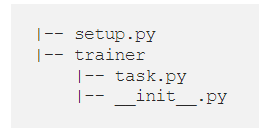

In [32]:
!python bundle2/setup.py sdist --format=gztar

running sdist
running egg_info
writing trainer.egg-info/PKG-INFO
writing dependency_links to trainer.egg-info/dependency_links.txt
writing top-level names to trainer.egg-info/top_level.txt
reading manifest file 'trainer.egg-info/SOURCES.txt'
writing manifest file 'trainer.egg-info/SOURCES.txt'

running check


creating trainer-0.1
creating trainer-0.1/trainer.egg-info
copying files to trainer-0.1...
copying trainer.egg-info/PKG-INFO -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/SOURCES.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/dependency_links.txt -> trainer-0.1/trainer.egg-info
copying trainer.egg-info/top_level.txt -> trainer-0.1/trainer.egg-info
Writing trainer-0.1/setup.cfg
creating dist
Creating tar archive
removing 'trainer-0.1' (and everything under it)


In [33]:
!gsutil cp bundle2/dist/trainer-0.1.tar.gz gs://ma-mx-presales-lab-bucket/vertex-end-to-end/python_code3/

Copying file://bundle2/dist/trainer-0.1.tar.gz [Content-Type=application/x-tar]...
/ [1 files][  473.0 B/  473.0 B]                                                
Operation completed over 1 objects/473.0 B.                                      


In [34]:
!gcloud beta ai custom-jobs create --region=us-central1 --display-name=e2e-tutorial-dropout --config=config.yaml

Using endpoint [https://us-central1-aiplatform.googleapis.com/]
CustomJob [projects/825075454589/locations/us-central1/customJobs/4670051394164621312] is submitted successfully.

Your job is still active. You may view the status of your job with the command

  $ gcloud beta ai custom-jobs describe projects/825075454589/locations/us-central1/customJobs/4670051394164621312

or continue streaming the logs with the command

  $ gcloud beta ai custom-jobs stream-logs projects/825075454589/locations/us-central1/customJobs/4670051394164621312


---

### Tensorboard

**Local**

In [28]:
!tensorboard --logdir gs://ma-mx-presales-lab-bucket/vertex-end-to-end/logs


NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.7.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C


In [ ]:
!tensorboard dev upload --logdir gs://ma-mx-presales-lab-bucket/vertex-end-to-end/logs/ --name "Simple experiment" --description "Training results from " --one_shot


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/WhBdY1FvTwqYN0MiQF1IzA/

[2022-02-18T00:26:01] Started scanning logdir.
[2022-02-18T00:26:02] Total uploaded: 18 scalars, 30 tensors (21.5 kB), 1 binary objects (60.8 kB)
[2022-02-18T00:26:02] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/WhBdY1FvTwqYN0MiQF1IzA/
